Przeriwdywanie trendów  akcji na podstawie danych historycznych

In [1]:
import yfinance as yf

# Pobieranie danych dla wybranej spółki, np. Apple
df = yf.download('AAPL', start='2010-01-01', end='2020-01-01')


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Używamy tylko kolumny 'Close' do prognozowania
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiory treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape danych do formatu [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Tworzenie modelu LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Trenowanie modelu
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


c:\Users\barto\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0110
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.5110e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5377e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.1863e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.0379e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.5183e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.1632e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2499e-04
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5168e-04
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2322e-04
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.1657e-04
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.8871e-04
Epoch 13/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3114e-04
Epoch 14/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1202e-04
Epoch 15/50
62/62 ━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 0.09711516000391023


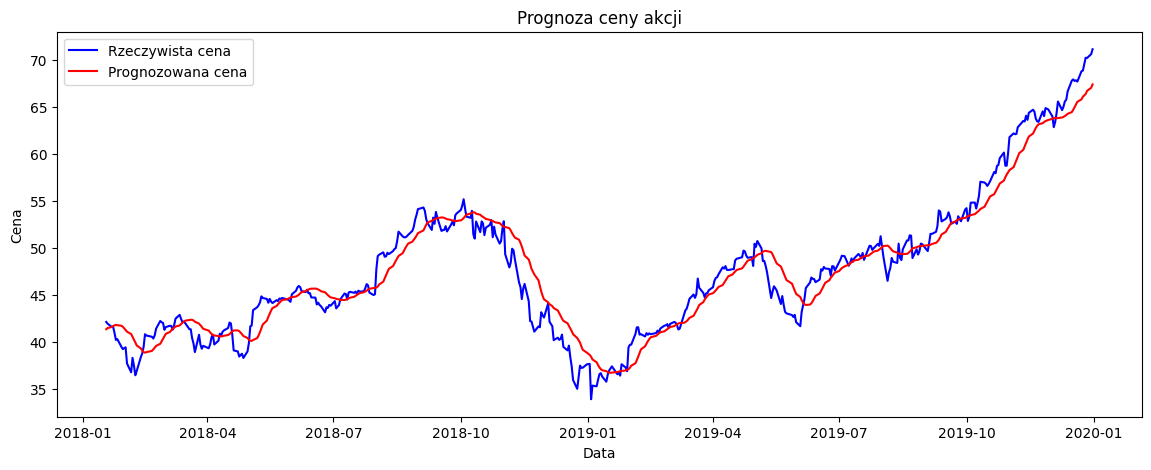

In [5]:
# Prognoza na danych testowych
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Odwrócenie normalizacji dla y_test
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Obliczenie błędu średniokwadratowego (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test_scaled)**2)
print(f'RMSE: {rmse}')

# Wizualizacja wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(df.index[-len(y_test):], y_test_scaled, color='blue', label='Rzeczywista cena')
plt.plot(df.index[-len(y_test):], predictions, color='red', label='Prognozowana cena')
plt.title('Prognoza ceny akcji')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend()
plt.show()
